In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import jax
import cv2
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax.numpy as jnp
from absl import app, flags
import optax
import json
import numpy as np
from functools import partial
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
# from palivla.dataset import prepare_image
from palivla.tokenizer import Tokenizer
from palivla.load_model import load_model_params_decode
from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from flax.training.train_state import TrainState
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.types import TrainingBatch, RolloutBatch

# export TPU_VISIBLE_DEVICES=0 
# export TPU_CHIPS_PER_HOST_BOUNDS=1,1,1 
# export TPU_HOST_BOUNDS=1,1,1 
# export TPU_MESH_CONTROLLER_ADDRESS=localhost:8476 
# export TPU_MESH_CONTROLLER_PORT=8476

os.environ['TPU_VISIBLE_DEVICES'] = '0'
os.environ['TPU_CHIPS_PER_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_MESH_CONTROLLER_ADDRESS'] = 'localhost:8476'
os.environ['TPU_MESH_CONTROLLER_PORT'] = '8476'


/nfs/nfs2/users/mitsuhiko/miniconda/envs/big_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-26 02:03:41.136507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732586621.155739 1740816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732586621.161521 1740816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 02:03:44.229666: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [14]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ind = np.random.randint(0, 1000)
ds = builder.as_dataset(split=f'train[{ind}:{ind+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (224, 224)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: Put the pepper to the left of the spoon.


In [ ]:


# action_mean = np.array(dataset_statistics[dataset_name]["action"]["mean"])
# action_std = np.array(dataset_statistics[dataset_name]["action"]["std"])
# action_mask = np.array(dataset_statistics[dataset_name]["action"]["mask"])
def make_inference_batch(batch):
    sensors = {
        k: batch["observation"][k][None].numpy()
        for k in batch["observation"]
        if k in model.model_state.model.modality_mappings and k != "text"
    }
    sensors_mask = {
        k: batch["observation"]["pad_mask_dict"][k].numpy()
        for k in model.model_state.model.modality_mappings
        if k != "text"
    }
    return RolloutBatch(
            sensor_data=sensors,
            sensor_masks=sensors_mask,
            prompt=batch["tokens"][None].numpy(),
            prompt_mask=batch["mask_input"][None].numpy(),
            prompt_ar=np.zeros_like(batch["mask_ar"][None]),
        )
    

# Do inference
def do_inference(images, instructions):
    data = {
        "observation": {"image_primary": images, "pad_mask_dict": {"image_primary": tf.ones(len(images), dtype=tf.bool)}},
        "task": {"language_instruction": instructions},
    }
    language_token_instructions = tokenizer.tokenize_language_instruction(data)
    # batch = prepare_image(batch)
    batch = tokenizer.prepare_tokens_for_generation(data, language_token_instructions)
    batch = batch | data
    rollout_batch = make_inference_batch(batch)

    out_tokens, value = decode(
        rollout_batch, None
    )
    out_tokens = jax.device_get(multihost_utils.process_allgather(out_tokens))
    value = jax.device_get(multihost_utils.process_allgather(value))
    decoded_actions = tokenizer.detokenize_action(out_tokens)

    # Re-normalize actions using dataset statistics
    # decoded_actions = decoded_actions * action_std + action_mean
    # decoded_actions = unnormalize_action(decoded_actions, dataset_statistics[dataset_name]["action"])
    decoded_actions = unnormalize_action_minmax(decoded_actions, dataset_statistics[dataset_name]["action"])

    return decoded_actions, value

def unnormalize_action(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action * unnormalization_statistics["std"])
        + unnormalization_statistics["mean"],
        action,
    )
    return action

def unnormalize_action_minmax(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action + 1) / 2 * (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) + unnormalization_statistics["p01"],
        action,
    )

    return action

In [34]:
resume_from_checkpoint_dir = "gs://rail-tpus-mitsuhiko-central2/logs/test/mild-firebrand-12/"
# resume_from_checkpoint_step = "gs://rail-tpus-mitsuhiko-central2/logs/test/bright-thunder-2/"
resume_from_checkpoint_step = 100000
dataset_name = "bridge_dataset"

In [35]:
# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])

model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")
# data_sharding = jax.sharding.SingleDeviceSharding(jax.local_devices()[0])

restore_checkpoint_manager = ocp.CheckpointManager(
        resume_from_checkpoint_dir,
        item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)

model = PaliVLATrainState.restore(
        checkpoint_manager=restore_checkpoint_manager,
        step=resume_from_checkpoint_step,
        load_optimizer=False,
        mesh=mesh,
        model_sharding=model_sharding,
        data_sharding=data_sharding,
    )
tokenizer = model.tokenizer
decode = model.decode
dataset_statistics = model.dataset_statistics


In [36]:
tokenizer

Tokenizer(config=Tokenizer.TokenizerConfig(action_vocab_size=256, action_vocab_offset=256000, vocab_size=<bound method SentencepieceTokenizer.vocab_size of <tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7fc17811fc70>>, num_action_tokens=7, bos_token=2, eos_token=1, pad_token=0, begin_of_action_token=108, end_of_action_token=3, max_pad_length=60, min_action_value=-2, max_action_value=2, prompt_autoregressive=False), language_tokenizer=<tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7fc17811fc70>, token_structure=FrozenDict({
    causal: ('action', (3,)),
    pad: ((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),),
    prefix: ((2,), 'prompt', (108,)),
}), action_tokenizer=BinActionTokenizer(
    # attributes
    min_action_value = -2
    max_action_value = 2
    action_dim = 7
 

## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [37]:
WINDOW_SIZE = 1
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
pred_values = []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_image = images[step][None]
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1.0
    instruction = tf.constant(language_instruction)
    
    actions, value = do_inference(input_image, instruction)
    print(value, actions)
    pred_actions.append(actions)
    pred_values.append(value)

    true_actions.append(np.concatenate(
        (
            steps[step]['action']['world_vector'], 
            steps[step]['action']['rotation_delta'], 
            np.array(steps[step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

  0%|          | 0/33 [00:00<?, ?it/s]

[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]


  6%|▌         | 2/33 [00:00<00:06,  4.60it/s]

-12.91958 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.957978 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


  9%|▉         | 3/33 [00:00<00:06,  4.77it/s]

[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.024815 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]


 12%|█▏        | 4/33 [00:00<00:05,  4.86it/s]

[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.995863 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]


 15%|█▌        | 5/33 [00:01<00:05,  4.93it/s]

[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.823713 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]


 18%|█▊        | 6/33 [00:01<00:05,  4.96it/s]

[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.984942 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]


 21%|██        | 7/33 [00:01<00:05,  4.97it/s]

[[256133]]
[[256128]]
[[256192]]
-12.944136 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]


 24%|██▍       | 8/33 [00:01<00:05,  4.98it/s]

[[256128]]
[[256192]]
-12.9984665 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]


 27%|██▋       | 9/33 [00:01<00:04,  4.98it/s]

[[256192]]
-13.355378 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]


 33%|███▎      | 11/33 [00:02<00:04,  5.00it/s]

-13.357412 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.197672 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 36%|███▋      | 12/33 [00:02<00:04,  5.00it/s]

[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.115865 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]


 39%|███▉      | 13/33 [00:02<00:04,  5.00it/s]

[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.115898 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]


 42%|████▏     | 14/33 [00:02<00:03,  5.01it/s]

[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.04894 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]


 45%|████▌     | 15/33 [00:03<00:03,  5.01it/s]

[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.919714 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]


 48%|████▊     | 16/33 [00:03<00:03,  5.02it/s]

[[256133]]
[[256128]]
[[256192]]
-12.828407 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]


 52%|█████▏    | 17/33 [00:03<00:03,  4.99it/s]

[[256133]]
[[256128]]
[[256192]]
-12.783183 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]


 55%|█████▍    | 18/33 [00:03<00:02,  5.00it/s]

[[256128]]
[[256192]]
-12.81599 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]


 58%|█████▊    | 19/33 [00:03<00:02,  5.02it/s]

[[256192]]
-12.864842 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]


 64%|██████▎   | 21/33 [00:04<00:02,  5.03it/s]

-13.147053 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.852966 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 67%|██████▋   | 22/33 [00:04<00:02,  5.03it/s]

[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.886763 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]


 70%|██████▉   | 23/33 [00:04<00:01,  5.02it/s]

[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.891623 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]


 73%|███████▎  | 24/33 [00:04<00:01,  5.03it/s]

[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.976933 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]


 76%|███████▌  | 25/33 [00:05<00:01,  5.03it/s]

[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.917897 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]


 79%|███████▉  | 26/33 [00:05<00:01,  5.03it/s]

[[256133]]
[[256128]]
[[256192]]
-12.903127 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]


 82%|████████▏ | 27/33 [00:05<00:01,  5.05it/s]

[[256128]]
[[256192]]
-12.993124 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]


 85%|████████▍ | 28/33 [00:05<00:00,  5.04it/s]

[[256192]]
-13.37412 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]


 88%|████████▊ | 29/33 [00:05<00:00,  5.03it/s]

-13.125658 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-12.977057 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 94%|█████████▍| 31/33 [00:06<00:00,  5.03it/s]

[[256128]]
[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.062202 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]


 97%|█████████▋| 32/33 [00:06<00:00,  5.03it/s]

[[256128]]
[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.017298 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
[[256128]]
[[256128]]


100%|██████████| 33/33 [00:06<00:00,  4.98it/s]

[[256114]]
[[256127]]
[[256133]]
[[256128]]
[[256192]]
-13.010088 [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


In [38]:
np.array(pred_actions).shape

(33, 1, 1, 7)

## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

/tmp/ipykernel_1740816/1693310813.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


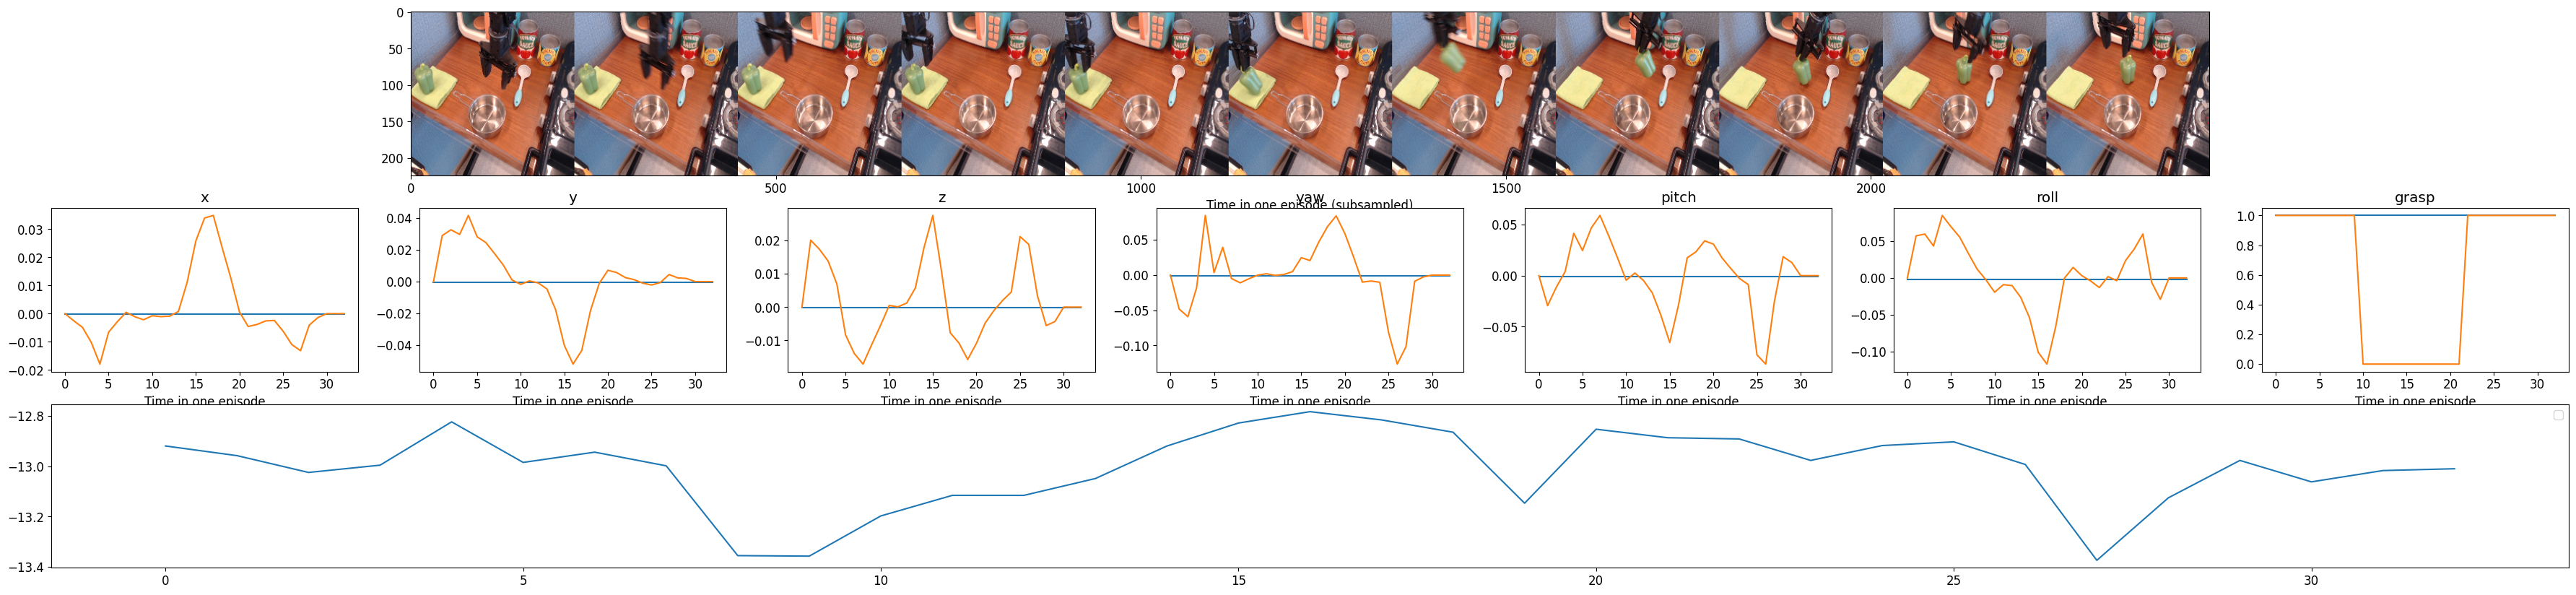

In [39]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS,
    ["value"] * len(ACTION_DIM_LABELS),
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

# plot value
axs['value'].plot(pred_values)

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()